In [1]:
import numpy as np
import sacc
import matplotlib.pyplot as plt
import pyccl as ccl
import scipy
import importlib as imp
import astropy.io.fits as fits
import yaml
import time
from itertools import islice, cycle
import os

# import main.py Then we can have some more general/vague benefits that can include some of the things in your list belowfrom TJPCov folder
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

## Definitions from other file

In [2]:
def cov2corr(cov):
    """
    Convert a covariance matrix into a correlation matrix
    input:
        cov: numpy.array with dim:(N,N)
    returns:
        corr: numpy.array with dim:(N,N)
    """
    sig = np.sqrt(cov.diagonal())
    return cov/np.outer(sig, sig)

In [68]:
""" Get a binned redshift distribution - defining functions """

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    
    alpha = 1.27
    beta = 1.02
    z0 = 0.3
    pz = z**alpha * np.exp(-(z / z0)**beta)                                # Redshift distribution, p(z)
    return pz

# complete binning of z so that integral of redshiftdist(z) between bins stays the same. Need redshiftdist(z) to be Normalized
# (in limit of large z linspace)

def bindist(z, n_bins):
                                                                          # have redshiftdist(z), z 
                                                                          # find bins: integrate between 0 and i redshift(z)
                                                                          #            if integral => 1/n_bin, that is a bin
                                                                          #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

# define gaussian photo-z uncertainties

def gaussianphotoz(zs , zp):
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

# bins distribution for redshiftdist(z) in n_bins with same number of galaxies in each bin, smoothened by gaussianphotoz(zs , zp) kernel

def binning_redshiftdist(z , n_bins):
    
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel

    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [69]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.001 , 3.0 , int(1e4))

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 5)[0]

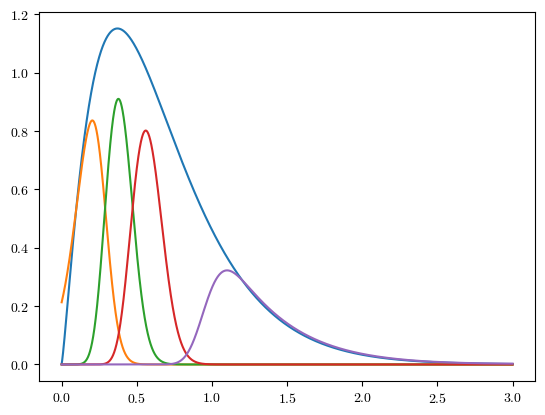

In [85]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[len(Binned_distribution)-1])


In [101]:
""" Ell binning """

# define ell and C_ell shapes 

ell_min = 2
ell_max = 2060

# define quantities for binning of ell

ell_bin_num = 18

ell = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num)

print(len(ell))

18


## Finding Cov

In [71]:
print(sacc.standard_types)

- cl_00
- cl_0e
- cl_0b
- cl_e0
- cl_b0
- cl_ee
- cl_eb
- cl_be
- cl_bb
- xi_00
- xi_0e
- xi_0b
- xi_e0
- xi_b0
- xi_plus_re
- xi_plus_im
- xi_minus_re
- xi_minus_im
- count
- cluster_counts
- cluster_mean_log_mass
- cluster_shear
- clusterGalaxy_densityConvergence_cl
- clusterGalaxy_densityConvergence_xi
- clusterGalaxy_densityShear_cl_b
- clusterGalaxy_densityShear_cl_e
- clusterGalaxy_densityShear_xi_t
- clusterGalaxy_densityShear_xi_x
- clusterGalaxy_density_cl
- clusterGalaxy_density_xi
- cluster_density_cl
- cluster_density_xi
- cluster_mass_count_wl
- cluster_mass_count_xray
- cmbCluster_polarizationDensity_cl_b
- cmbCluster_polarizationDensity_cl_e
- cmbCluster_polarizationDensity_xi_t
- cmbCluster_polarizationDensity_xi_x
- cmbCluster_temperatureDensity_cl
- cmbCluster_temperatureDensity_xi
- cmbCluster_convergenceDensity_cl
- cmbCluster_convergenceDensity_xi
- cmbGalaxy_convergenceDensity_cl
- cmbGalaxy_convergenceDensity_xi
- cmbGalaxy_convergenceShear_cl_b
- cmbGalaxy_conve

In [72]:
# load in cosmology object from yaml
cosmo = ccl.Cosmology.read_yaml('Covariance_understanding/cosmo_MCMC.yaml')

In [102]:
"""Define sacc file - Cl^{ij}(ell) for some ell bins and redshift bins"""
# My redshifts (for now)
src0 = Binned_distribution[0]
src1 = Binned_distribution[1]
src2 = Binned_distribution[2]
src3 = Binned_distribution[3]
src4 = Binned_distribution[4]
z_src = z

ell_bins = ell

# z binning 

src_bins = [src0, src1, src2, src3, src4]

s = sacc.Sacc()

for i, bin1 in enumerate(src_bins):
    for j, bin2 in enumerate(src_bins):
        if j > i:
            break
        s.add_tracer('NZ', 'src%d'%i, z=z_src, nz=bin1)

        # construct Cl_gM for sacc file
        shearA = ccl.WeakLensingTracer(cosmo, dndz=(z_src, bin1), has_shear=True)
        shearB = ccl.WeakLensingTracer(cosmo, dndz=(z_src, bin2), has_shear=True)

        Cl = ccl.angular_cl(cosmo, shearA, shearB, ell) 
        # bin ell

        s.add_ell_cl('galaxy_shear_cl_ee', 'src%d'%i, 
                            'src%d'%j, ell, Cl, tracers_later=True)

s.save_fits('/home/c2042999/PCA_project/Covariance_understanding/cl_and_xi_data.fits', overwrite=True)

In [103]:
s = sacc.Sacc.load_fits("/home/c2042999/PCA_project/Covariance_understanding/cl_and_xi_data.fits")
dts = s.get_data_types()
tracer_sets = s.get_tracer_combinations(s)

/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sacc/sacc.py:376: UserWarning: Empty index selected
  warnings.warn("Empty index selected")


In [104]:
print(dts)
print(tracer_sets)
print((s.get_ell_cl('galaxy_shear_cl_ee','src0','src0')))

['galaxy_shear_cl_ee']
[]
(array([2.00000000e+00, 3.00784682e+00, 4.52357124e+00, 6.80310467e+00,
       1.02313484e+01, 1.53871643e+01, 2.31411166e+01, 3.48024669e+01,
       5.23402447e+01, 7.87157192e+01, 1.18382413e+02, 1.78038081e+02,
       2.67755638e+02, 4.02683972e+02, 6.05605852e+02, 9.10784817e+02,
       1.36975061e+03, 2.06000000e+03]), array([4.25855005e-09, 5.08673797e-09, 4.89285833e-09, 4.06352848e-09,
       3.01036651e-09, 2.04800581e-09, 1.31098306e-09, 7.97394420e-10,
       4.73762602e-10, 2.85574699e-10, 1.76809485e-10, 1.11726520e-10,
       7.01928093e-11, 4.25031362e-11, 2.42018580e-11, 1.27833235e-11,
       6.25410363e-12, 2.86165436e-12]))


In [105]:
config = '/home/c2042999/PCA_project/Covariance_understanding/Fourier_cosmic_shear_gauss.yaml'

gauss_calc = CovarianceCalculator(config)

# get matrix
gauss_cov = gauss_calc.get_covariance()

Computing independent covariance blocks
Rank None: ('src0', 'src0'), ('src0', 'src0')


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/tjpcov/covariance_builder.py:887: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Rank None: ('src0', 'src0'), ('src1', 'src0')


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


Rank None: ('src0', 'src0'), ('src1', 'src1')
Rank None: ('src0', 'src0'), ('src2', 'src0')
Rank None: ('src0', 'src0'), ('src2', 'src1')
Rank None: ('src0', 'src0'), ('src2', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src0')
Rank None: ('src0', 'src0'), ('src3', 'src1')
Rank None: ('src0', 'src0'), ('src3', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src0')
Rank None: ('src0', 'src0'), ('src4', 'src1')
Rank None: ('src0', 'src0'), ('src4', 'src2')
Rank None: ('src0', 'src0'), ('src4', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src4')
Rank None: ('src1', 'src0'), ('src1', 'src0')
Rank None: ('src1', 'src0'), ('src1', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src0')
Rank None: ('src1', 'src0'), ('src2', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src2')
Rank None: ('src1', 'src0'), ('src3', 'src0')
Rank None: ('src1', 'src0'), ('src3', 'src1')
Rank None: ('src1', 'src0'), ('src3', 'src2')
Rank None: ('src1', 'src0'), ('src

In [106]:
print(np.min(gauss_cov))
print(np.max(gauss_cov))

0.0
1.9190189759415838e-19


(270, 270)


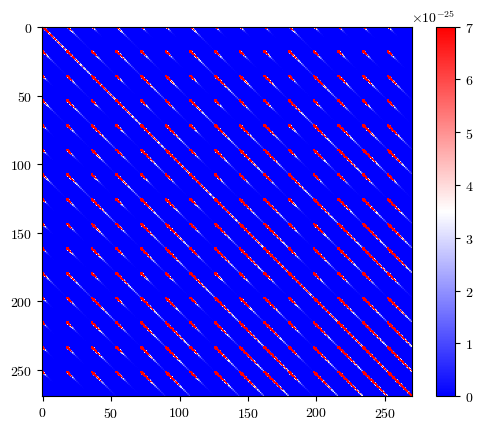

In [107]:
print(gauss_cov.shape)
plt.imshow(gauss_cov, origin='upper',  vmin=0, vmax=7e-25, cmap='bwr')
plt.colorbar()
plt.show()

(270, 270)


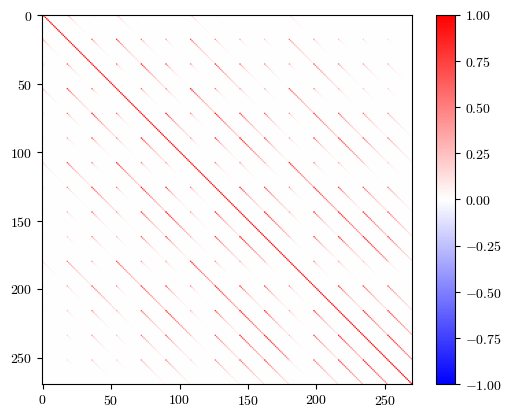

In [88]:
corr = cov2corr(gauss_cov)
print(corr.shape)
plt.imshow(corr, origin='upper', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.show()